In [ ]:
#!pip install --quiet git+https://github.com/songlab-cal/gpn

# Setup

In [1]:
from gpn.star.data import GenomeMSA, Tokenizer
import gpn.star.model
from gpn.star.utils import find_directory_sum_paths, normalize_logits

import numpy as np
import pandas as pd
import torch
from transformers import AutoModel, AutoConfig, AutoModelForMaskedLM
from huggingface_hub import hf_hub_download, snapshot_download
import matplotlib.pyplot as plt
import os
import seaborn as sns

/accounts/grad/czye/conda/envs/gpn_env/envs/gpn_star/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
WORKING_DIR = "/accounts/grad/czye/GPN/gpn/examples/star/tmp/"

os.makedirs(WORKING_DIR, exist_ok=True)

# Download the model

Pick one model from the following

Here we use the vertebrate alignment model as an example

## GPN-Star for hg38 with 100 vertebrate alignment

In [3]:
snapshot_download(
    repo_id="songlab/gpn-star-hg38-v100-200m",
    local_dir=WORKING_DIR + "gpn-star-hg38-v100-200m",
)
model_path = WORKING_DIR + "gpn-star-hg38-v100-200m"

Fetching 9 files: 100%|██████████| 9/9 [00:00<00:00, 1464.49it/s]


## GPN-Star for hg38 with 447 mammal alignment

In [4]:
# snapshot_download(repo_id="songlab/gpn-star-hg38-m447-200m", local_dir=WORKING_DIR+"gpn-star-hg38-m447-200m")
# model_path = WORKING_DIR+"gpn-star-hg38-m447-200m"

## GPN-Star for hg38 with 243 primate alignment

In [5]:
# snapshot_download(repo_id="songlab/gpn-star-hg38-p243-200m", local_dir=WORKING_DIR+"gpn-star-hg38-p243-200m")
# model_path = WORKING_DIR+"gpn-star-hg38-p243-200m"

# Download corresponding alignment data

## multiz100way (100 vertebrates)

download and decompress

In [ ]:
############################################################
# takes a few hours, can run the commands in terminal
############################################################
hf_hub_download(
    repo_id="songlab/multiz100way-pigz",
    filename="99.zarr.tar.gz",
    local_dir=WORKING_DIR + "multiz100way",
    repo_type="dataset",
)  # ~42GB
# alternatively, download in CLI
# os.system(f"hf download songlab/multiz100way-pigz --local-dir {WORKING_DIR}multiz100way --repo-type dataset")

# decompress
os.system(f"unpigz < {WORKING_DIR}multiz100way/99.zarr.tar.gz | tar -x")
############################################################

wga_paths = {100: WORKING_DIR + "multiz100way/99.zarr"}

## cactus447way (447 mammals)

download and decompress

*Note*: this alignment is divided into two parts: 243 primates and 204 non-primates

need to download both parts and provide both paths

In [7]:
# hf_hub_download(repo_id="songlab/hg38_cactus447way",
#                 filename="243.tar.gz",
#                 local_dir=WORKING_DIR+"cactus447way",
#                 repo_type="dataset") # ~40GB
# os.system(f"unpigz < {WORKING_DIR}cactus447way/243.tar.gz | tar -x")

# hf_hub_download(repo_id="songlab/hg38_cactus447way",
#                 filename="204.tar.gz",
#                 local_dir=WORKING_DIR+"cactus447way",
#                 repo_type="dataset") # ~66GB
# os.system(f"unpigz < {WORKING_DIR}cactus447way/204.tar.gz | tar -x")

# wga_paths = {243: WORKING_DIR+"cactus447way/243/all.zarr",
#              204: WORKING_DIR+"cactus447way/204/all.zarr"}

## cactus447way (243 primates)

download and decompress

the primate model uses the 243-primate part of the cactus447way alignment

In [8]:
# hf_hub_download(repo_id="songlab/hg38_cactus447way",
#                 filename="243.tar.gz",
#                 local_dir=WORKING_DIR+"cactus447way",
#                 repo_type="dataset") # ~40GB
# os.system(f"unpigz < {WORKING_DIR}cactus447way/243.tar.gz | tar -x")

# wga_paths = {243: WORKING_DIR+"cactus447way/243/all.zarr"}

# Load input data

Example region: chr6:31575665-31575793

[UCSC Genome Browser view](https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr6%3A31575665%2D31575793&hgsid=1726885238_vIMnX2NGEluaKCXVZjeTkj97aydM) 

In [5]:
genome_msa_list = [
    GenomeMSA(path, n_species=n_species, in_memory=False)
    for n_species, path in wga_paths.items()
]

Loading MSA...
Loading MSA... Done


In [ ]:
##### In standard VEP, use both the forward and reverse strand #####

# msa_fwd, msa_rev = zip(*[
#     genome_msa.get_msa_batch_fwd_rev(chrom, start, end, tokenize=True)
#     for genome_msa in self.genome_msa_list
# ])
# msa_fwd = np.concatenate(msa_fwd, axis=-1)
# msa_rev = np.concatenate(msa_rev, axis=-1)

In [6]:
# Here we use a single strand just for demonstration
raw_msa = [
    genome_msa.get_msa("6", 31575665, 31575793, strand="+", tokenize=False)
    for genome_msa in genome_msa_list
]
raw_msa = np.concatenate(raw_msa, axis=-1)
print(raw_msa.shape)
raw_msa

(128, 100)


array([[b'A', b'A', b'A', ..., b'-', b'-', b'-'],
       [b'C', b'C', b'C', ..., b'-', b'-', b'-'],
       [b'A', b'A', b'A', ..., b'-', b'-', b'-'],
       ...,
       [b'T', b'T', b'T', ..., b'-', b'-', b'-'],
       [b'C', b'C', b'C', ..., b'-', b'-', b'-'],
       [b'C', b'C', b'C', ..., b'-', b'-', b'-']],
      shape=(128, 100), dtype='|S1')

In [7]:
msa = [
    genome_msa.get_msa("6", 31575665, 31575793, strand="+", tokenize=True)
    for genome_msa in genome_msa_list
]
msa = np.concatenate(msa, axis=-1)
print(msa.shape)
msa

(128, 100)


array([[1, 1, 1, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [4, 4, 4, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0]], shape=(128, 100), dtype=uint8)

In [8]:
msa = torch.tensor(np.expand_dims(msa, 0).astype(np.int64))
msa

tensor([[[1, 1, 1,  ..., 0, 0, 0],
         [2, 2, 2,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [4, 4, 4,  ..., 0, 0, 0],
         [2, 2, 2,  ..., 0, 0, 0],
         [2, 2, 2,  ..., 0, 0, 0]]])

In [9]:
# define human as the target species and use all species as source species
input_ids, source_ids = msa[:, :, :1], msa
input_ids.shape, source_ids.shape

(torch.Size([1, 128, 1]), torch.Size([1, 128, 100]))

# Get logits (log probabilities)

In [10]:
config = AutoConfig.from_pretrained(model_path + "/config.json")

In [11]:
config.phylo_dist_path = model_path + "/phylo_dist/"

In [12]:
model_for_mlm = AutoModelForMaskedLM.from_pretrained(model_path, config=config)
model_for_mlm.eval()

GPNStarForMaskedLM(
  (model): GPNStarModel(
    (target_embedding): GPNStarEmbedding(
      (input_embed): Embedding(6, 1024)
    )
    (source_embedding): GPNStarSourceModule(
      (attn_pool): GPNStarAttentionPool(
        (attention_weights): Embedding(6, 8)
        (value): Embedding(6, 512)
        (dropout): Dropout(p=0.1, inplace=False)
        (ffn): Linear(in_features=512, out_features=1024, bias=True)
      )
      (embed): Embedding(6, 1024)
      (embed_positions): FIRETimeBias(
        (mlp): Sequential(
          (0): Linear(in_features=1, out_features=32, bias=False)
          (1): SiLU()
          (2): Linear(in_features=32, out_features=1, bias=False)
        )
      )
    )
    (encoder): GPNStarEncoder(
      (embed_positions): RoFormerSinusoidalPositionalEmbedding(1536, 64)
      (layer): ModuleList(
        (0-15): 16 x GPNStarLayer(
          (attention): GPNStarAttention(
            (row_attention): GPNStarRowAttention(
              (self): GPNStarRowSelfAtte

In [13]:
raw_msa[76:79, 0]  # Start codon

array([b'A', b'T', b'G'], dtype='|S1')

In [14]:
tokenizer = Tokenizer()
pos = 76  # Let's mask the A and check the model predictions
input_ids[0, pos] = tokenizer.mask_token_id()

In [15]:
input_ids.shape

torch.Size([1, 128, 1])

In [16]:
with torch.no_grad():
    all_logits = model_for_mlm.forward(
        input_ids=input_ids,
        source_ids=source_ids,
        target_species=np.array([[0]], dtype=int),
    ).logits
all_logits.shape  # (batch_size, seq_len, num_target, vocab_size)

/accounts/grad/czye/conda/envs/gpn_env/envs/gpn_star/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


torch.Size([1, 128, 1, 6])

In [19]:
nucleotides = list("ACGT")
logits = all_logits.squeeze()[pos, [tokenizer.vocab.index(nc) for nc in nucleotides]]
logits

tensor([ 7.7062, -1.9220, -0.6912, -2.6507])

In [20]:
probs = torch.nn.functional.softmax(logits, dim=0).numpy()
probs

array([9.9967706e-01, 6.5820524e-05, 2.2536943e-04, 3.1760745e-05],
      dtype=float32)

<Axes: xlabel='nucleotide', ylabel='probability'>

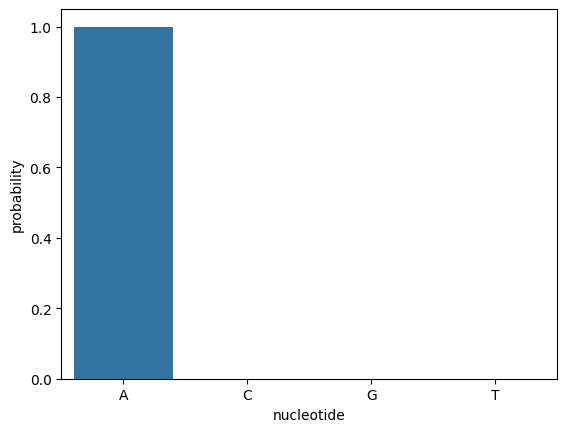

In [21]:
probs_df = pd.DataFrame(dict(nucleotide=nucleotides, probability=probs))
sns.barplot(data=probs_df, x="nucleotide", y="probability")

# Get log-likelihood ratio (LLR)

In [29]:
# get reference allele
ref = raw_msa[pos, 0].decode()
ref

'A'

In [56]:
# get the LLR for the three alternative alleles
alt_alleles = [nc for nc in nucleotides if nc != ref]
ref_logit = logits[nucleotides.index(ref)]
alt_logits = [logits[nucleotides.index(alt)] for alt in alt_alleles]
variant = [f"{ref}>{alt}" for alt in alt_alleles]
llrs = [alt_logit.item() - ref_logit.item() for alt_logit in alt_logits]
llr_df = pd.DataFrame(dict(variant=variant, alt_allele=alt_alleles, LLR=llrs))
print(llr_df)

  variant alt_allele        LLR
0     A>C          C  -9.628256
1     A>G          G  -8.397447
2     A>T          T -10.356957


<Axes: xlabel='variant', ylabel='LLR'>

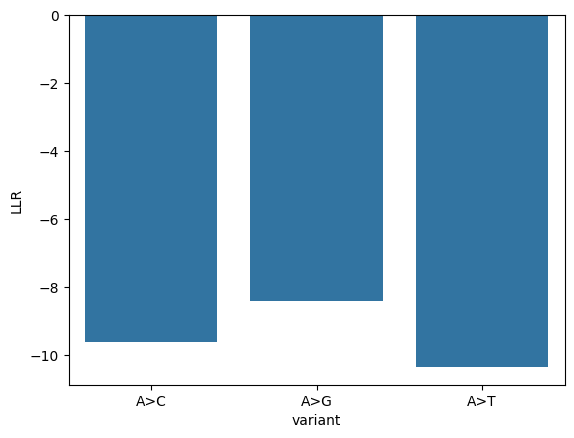

In [50]:
sns.barplot(data=llr_df, x="variant", y="LLR")

# Mutation rate calibration

calibrate the LLRs with precomputed neutral scores

In [43]:
# get the central pentanucleotide context
pentanuc = "".join(raw_msa[pos - 2 : pos + 3, 0].astype(str))
print(pentanuc)

CCATG


In [46]:
# get the corresponding neutral scores
calibration_table = pd.read_parquet(model_path + "/calibration_table/llr.parquet")
calibration_table

,pentanuc_mut,llr_neutral_mean
0,AAAAA_C,-1.372231
1,AAAAA_G,-1.147643
2,AAAAA_T,-1.374090
3,AAAAC_C,-1.359494
4,AAAAC_G,-1.237000
...,...,...
3067,TTTTG_C,-1.065968
3068,TTTTG_G,-1.301936
3069,TTTTT_A,-1.371902
3070,TTTTT_C,-1.184162


In [57]:
# calibrate the LLRs
llr_df["pentanuc"] = pentanuc
llr_df["pentanuc_mut"] = llr_df["pentanuc"] + "_" + llr_df["alt_allele"]
llr_df = llr_df.merge(calibration_table, on="pentanuc_mut", how="left")
llr_df["LLR_calibrated"] = llr_df["LLR"] - llr_df["llr_neutral_mean"]
llr_df

,variant,alt_allele,LLR,pentanuc,pentanuc_mut,llr_neutral_mean,LLR_calibrated
0,A>C,C,-9.628256,CCATG,CCATG_C,-1.431537,-8.196719
1,A>G,G,-8.397447,CCATG,CCATG_G,-1.295980,-7.101466
2,A>T,T,-10.356957,CCATG,CCATG_T,-1.452028,-8.904929


<Axes: xlabel='variant', ylabel='LLR_calibrated'>

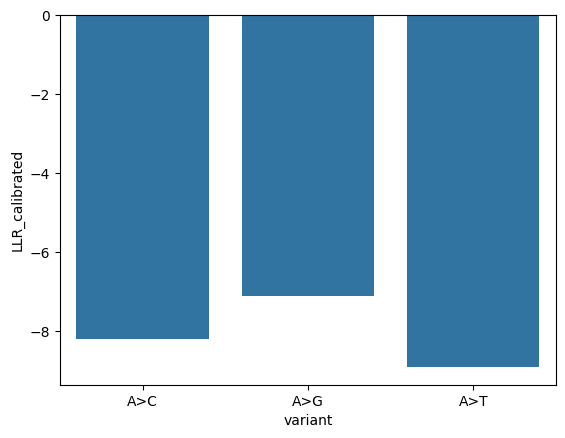

In [58]:
sns.barplot(data=llr_df, x="variant", y="LLR_calibrated")